In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data path
data_path = "/content/drive/MyDrive/Final_project/RealWaste"

Using device: cuda


## Data Transformation

In [ ]:
# Define augmented transformations to improve robustness
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # More aggressive cropping
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.2),  # Adding vertical flipping
        transforms.RandomRotation(20),  # Increase rotation range
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Enhance color jittering
        transforms.RandomGrayscale(p=0.05),  # Occasionally convert to grayscale
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Add blur augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# Custom Dataset class
class WasteDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = ImageFolder(root=root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

    @property
    def classes(self):
        return self.dataset.classes

    @property
    def targets(self):
        return self.dataset.targets

## Dataset Preparation and Handling Class Imbalance

This step involves loading the waste image dataset, applying data augmentations, and handling class imbalance using a weighted random sampler. The dataset is split into training and validation sets using stratified sampling to preserve class distribution. Custom subsets are created to apply the appropriate transformations for each split.


In [ ]:
# Create datasets and handle class imbalance
def create_datasets(data_dir, val_size=0.2):
    # Load dataset without transforms for initial split and weighting
    dataset_no_transform = WasteDataset(root_dir=data_dir, transform=None)

    # Get class distribution for calculating weights
    class_counts = np.bincount(dataset_no_transform.targets)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)

    # Create weighted sampler to handle class imbalance
    sample_weights = [class_weights[t] for t in dataset_no_transform.targets]

    # Split into train and validation
    train_indices, val_indices = train_test_split(
        list(range(len(dataset_no_transform))),
        test_size=val_size,
        stratify=dataset_no_transform.targets,  # Ensure stratified sampling
        random_state=42
    )

    # Custom subset datasets
    class CustomSubset(Dataset):
        def __init__(self, dataset, indices, transform=None):
            self.dataset = dataset
            self.indices = indices
            self.transform = transform
            self.targets = [dataset.targets[i] for i in indices]
            self.classes = dataset.classes

        def __len__(self):
            return len(self.indices)

        def __getitem__(self, idx):
            image, label = self.dataset[self.indices[idx]]
            # Apply transform only if it's present
            if self.transform:
                # Check if image is already a tensor, if so, convert to PIL Image
                if isinstance(image, torch.Tensor):
                    image = transforms.ToPILImage()(image)
                image = self.transform(image)
            return image, label

    # Create train and validation datasets using dataset_no_transform for base data
    train_dataset = CustomSubset(dataset_no_transform, train_indices, transform=data_transforms['train'])
    val_dataset = CustomSubset(dataset_no_transform, val_indices, transform=data_transforms['val'])

    # Get weights for training set
    train_weights = [sample_weights[i] for i in train_indices]
    train_sampler = WeightedRandomSampler(train_weights, len(train_weights))

    return train_dataset, val_dataset, train_sampler, val_dataset.classes

## Data Loading

Data loaders are created for both the training and validation datasets using a defined batch size. The training loader utilizes a weighted random sampler to address class imbalance, while the validation loader uses standard sequential sampling. This step also prints the number of samples in each split and the class labels.


In [ ]:
# Load data
train_dataset, val_dataset, train_sampler, class_names = create_datasets(data_path)

# Create dataloaders
batch_size = 16  # Smaller batch size for better generalization
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,  # Use weighted sampler
    num_workers=4
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

# Print dataset information
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Class names: {class_names}")

Number of training samples: 3432
Number of validation samples: 859
Class names: ['Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Analyzing the class distribution
helps visualize the number of samples per category, identify imbalances, and justify the use of weighted sampling in training.

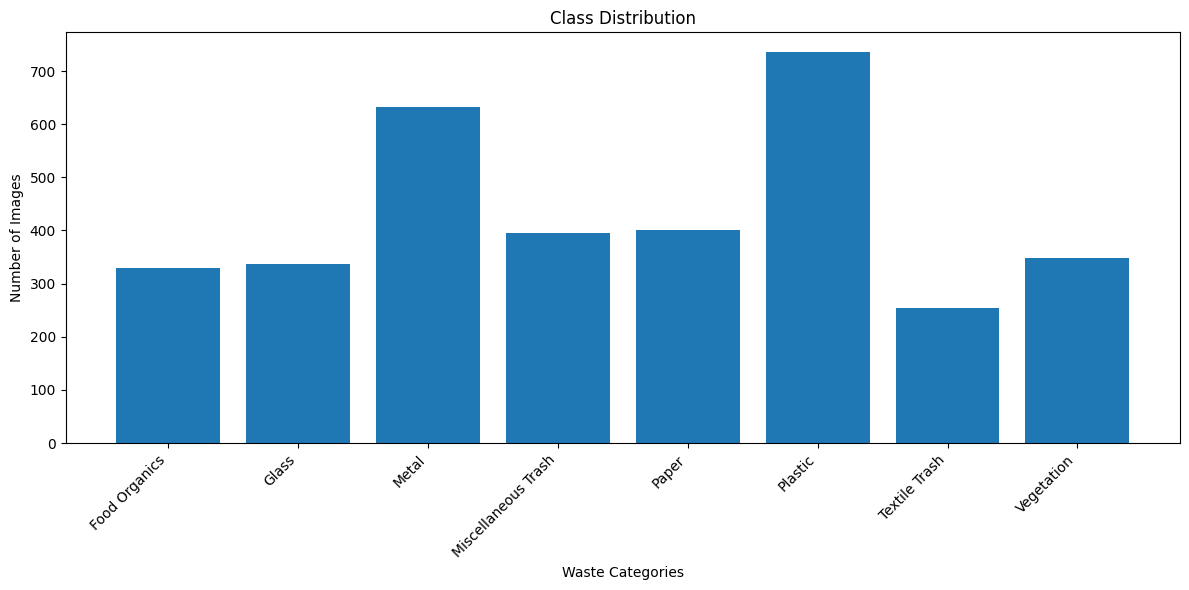

Class distribution:
Food Organics: 329 images (9.59%)
Glass: 336 images (9.79%)
Metal: 632 images (18.41%)
Miscellaneous Trash: 396 images (11.54%)
Paper: 400 images (11.66%)
Plastic: 736 images (21.45%)
Textile Trash: 254 images (7.40%)
Vegetation: 349 images (10.17%)


In [ ]:
# Analyze class distribution
def analyze_class_distribution(dataset, class_names):
    # Extract labels directly without applying transforms
    class_counts = np.bincount(dataset.targets)

    plt.figure(figsize=(12, 6))
    plt.bar(class_names, class_counts)
    plt.title('Class Distribution')
    plt.xlabel('Waste Categories')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("Class distribution:")
    for i, count in enumerate(class_counts):
        print(f"{class_names[i]}: {count} images ({count/sum(class_counts)*100:.2f}%)")

    return class_counts

# Print class distribution
class_counts = analyze_class_distribution(train_dataset, class_names)


## Model Architecture:
We use EfficientNet-B2 with pretrained ImageNet weights, freezing early layers and replacing the classifier to suit the number of waste categories.

In [ ]:
# Choose a better model for the task - EfficientNet instead of ResNet50
def create_model(num_classes):
    # Use EfficientNet-B2 which has better performance than ResNet50 typically
    model = models.efficientnet_b2(weights='IMAGENET1K_V1')

    # Freeze early layers
    for name, param in model.named_parameters():
        if 'features.0' in name or 'features.1' in name:
            param.requires_grad = False

    # Replace classifier
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(num_ftrs, num_classes)
    )

    return model

## Training Setup:
We define a custom training loop that includes data augmentation (mixup), class imbalance handling (with class weights), and early stopping. The model is optimized using the AdamW optimizer, with a OneCycle learning rate scheduler for dynamic learning rate adjustment. The best model is saved based on validation accuracy.

In [ ]:
# Create model
num_classes = len(class_names)
model = create_model(num_classes)
model = model.to(device)

# Define loss function with class weighting
class_counts = torch.tensor([class_counts[i] for i in range(len(class_names))], dtype=torch.float32)
class_weights = 1.0 / (class_counts / class_counts.sum())
class_weights = class_weights / class_weights.sum() * len(class_weights)
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# Use a more advanced optimizer: AdamW with weight decay
optimizer = optim.AdamW(
    [
        # Different learning rates for different parts of the model
        {'params': model.features.parameters(), 'lr': 0.0001},
        {'params': model.classifier.parameters(), 'lr': 0.001}
    ],
    weight_decay=0.01  # L2 regularization to prevent overfitting
)

# Learning rate scheduler with warmup
def get_scheduler(optimizer):
    return optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=[0.0005, 0.001],  # Different max learning rates for different parameter groups
        steps_per_epoch=len(train_loader),
        epochs=25,
        pct_start=0.2,  # 20% of training for warmup
        div_factor=25,  # Initial learning rate = max_lr/div_factor
        final_div_factor=1000  # Final learning rate = max_lr/final_div_factor
    )

scheduler = get_scheduler(optimizer)

# Early stopping to prevent overfitting
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Training function with mixup data augmentation
def mixup_data(x, y, alpha=0.2):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    early_stopping = EarlyStopping(patience=5)
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        processed_size = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            processed_size += inputs.size(0)

            # Apply mixup with 50% probability
            if np.random.random() < 0.5:
                inputs, labels_a, labels_b, lam = mixup_data(inputs, labels)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                # Calculate loss with mixup
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            else:
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                # Regular loss
                loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Print progress
            if processed_size % (len(train_dataset) // 5) < batch_size:
                print(f"Training: {processed_size}/{len(train_dataset)} samples processed")

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(val_dataset)
            epoch_acc = running_corrects.double() / len(val_dataset)

            history['val_loss'].append(epoch_loss)
            history['val_acc'].append(epoch_acc.item())

            print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save best model
            if epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                print(f"Saving best model with accuracy: {best_val_acc:.4f}")
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'class_names': class_names
                }, 'best_waste_model.pth')

        # Check early stopping
        early_stopping(epoch_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

        print()

    # Load the best model
    best_model_info = torch.load('best_waste_model.pth')
    model.load_state_dict(best_model_info['model_state_dict'])

    return model, history


## Training and Visualization:
The model is trained for 25 epochs to improve learning. After each epoch, the training and validation loss and accuracy are plotted to monitor the model’s performance and avoid overfitting. The metrics are saved as a PNG file for further analysis.

Epoch 1/25
----------
Training: 688/3432 samples processed
Training: 1376/3432 samples processed
Training: 2064/3432 samples processed
Training: 2752/3432 samples processed
Training: 3432/3432 samples processed
Train Loss: 1.7549 Acc: 0.3237
Val Loss: 1.2645 Acc: 0.5227
Saving best model with accuracy: 0.5227

Epoch 2/25
----------
Training: 688/3432 samples processed
Training: 1376/3432 samples processed
Training: 2064/3432 samples processed
Training: 2752/3432 samples processed
Training: 3432/3432 samples processed
Train Loss: 0.8979 Acc: 0.5353
Val Loss: 0.5854 Acc: 0.7660
Saving best model with accuracy: 0.7660

Epoch 3/25
----------
Training: 688/3432 samples processed
Training: 1376/3432 samples processed
Training: 2064/3432 samples processed
Training: 2752/3432 samples processed
Training: 3432/3432 samples processed
Train Loss: 0.6708 Acc: 0.6349
Val Loss: 0.4482 Acc: 0.8300
Saving best model with accuracy: 0.8300

Epoch 4/25
----------
Training: 688/3432 samples processed
Train

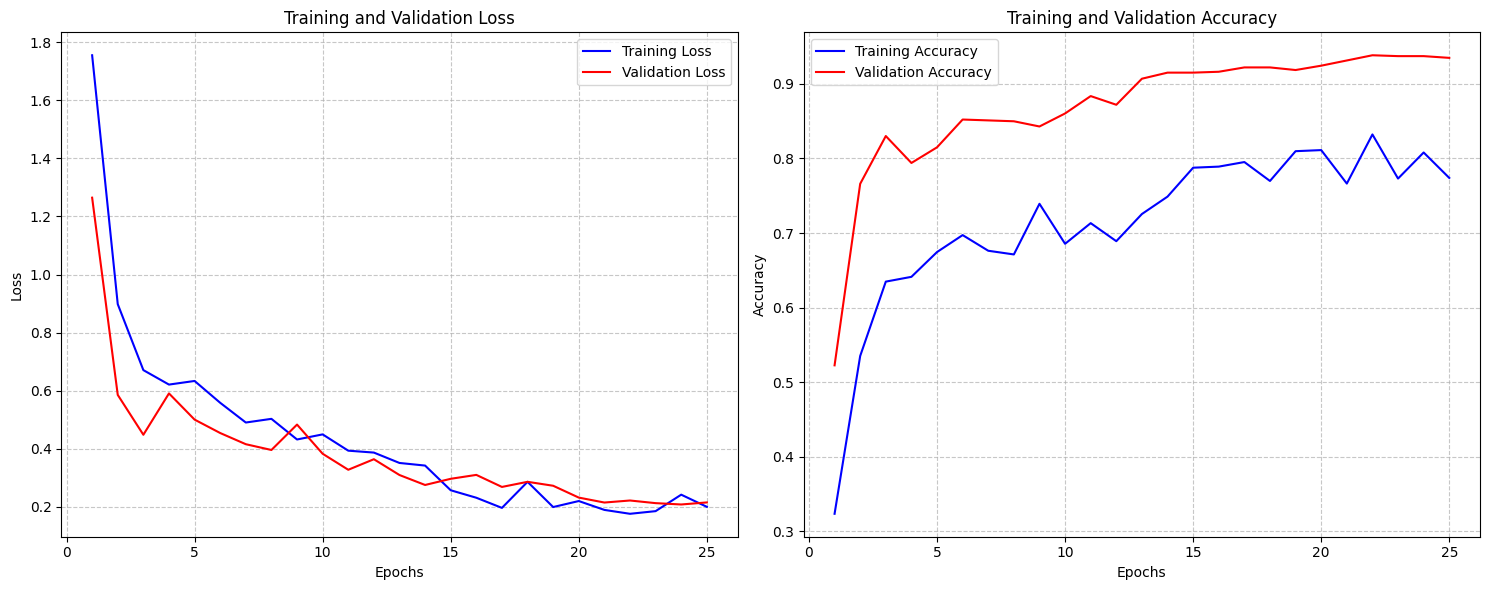

In [ ]:
# Train the model with more epochs
num_epochs = 25  # Increase epochs for better learning
model, history = train_model(model, [train_loader, val_loader], criterion, optimizer, scheduler, num_epochs)

# Plot training and validation metrics
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

plot_metrics(history)

# Model Evaluation for Waste Classification Task

## Introduction

After training the waste classification model using EfficientNet-B2, we evaluate its performance on a test dataset. This evaluation includes generating a classification report, confusion matrix, and calculating overall and per-class accuracy. The goal is to understand how well the model performs across different waste categories and identify areas for improvement.

## Evaluation Metrics

The following metrics are calculated to assess the performance of the model:

- **Classification Report**: Includes precision, recall, F1-score, and support for each class.
- **Confusion Matrix**: Visual representation of true vs predicted labels.
- **Overall Accuracy**: Proportion of correct predictions to total predictions.
- **Per-Class Accuracy**: Accuracy for each individual class.



In [ ]:
# Evaluate the model
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print classification report
    print("Classification Report:")
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Convert report to DataFrame for better visualization
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.round(3)
    print(report_df)

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Calculate overall accuracy
    accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f"Overall accuracy: {accuracy:.4f}")

    # Calculate per-class accuracy
    class_accuracy = {}
    for i, class_name in enumerate(class_names):
        class_mask = np.array(all_labels) == i
        if np.sum(class_mask) > 0:  # Avoid division by zero
            class_acc = np.sum((np.array(all_preds) == i) & class_mask) / np.sum(class_mask)
            class_accuracy[class_name] = class_acc
            print(f"Accuracy for class '{class_name}': {class_acc:.4f}")

    return accuracy, class_accuracy


# Model Evaluation and Prediction Pipeline

## Introduction

After evaluating the model on the validation set and saving it for future use, the next steps involve making predictions on new waste images. This process is enhanced with robust error handling and includes the prediction confidence, top 3 class predictions, and recyclability information for each waste category.

## Steps Involved

### 1. **Evaluate on Validation Set**

The model is evaluated on the validation set using the `evaluate_model` function. This function returns the accuracy and class-specific metrics for the validation data, helping us verify the model's generalization performance before moving to real-world predictions.


Classification Report:
                     precision    recall  f1-score   support

      Food Organics       0.95      0.98      0.96        82
              Glass       0.94      0.98      0.96        84
              Metal       0.94      0.96      0.95       158
Miscellaneous Trash       0.84      0.86      0.85        99
              Paper       0.93      0.99      0.96       100
            Plastic       0.96      0.90      0.93       185
      Textile Trash       0.95      0.92      0.94        64
         Vegetation       0.98      0.97      0.97        87

           accuracy                           0.94       859
          macro avg       0.94      0.94      0.94       859
       weighted avg       0.94      0.94      0.94       859

                     precision  recall  f1-score  support
Food Organics            0.952   0.976     0.964   82.000
Glass                    0.943   0.976     0.959   84.000
Metal                    0.944   0.956     0.950  158.000
Miscellane

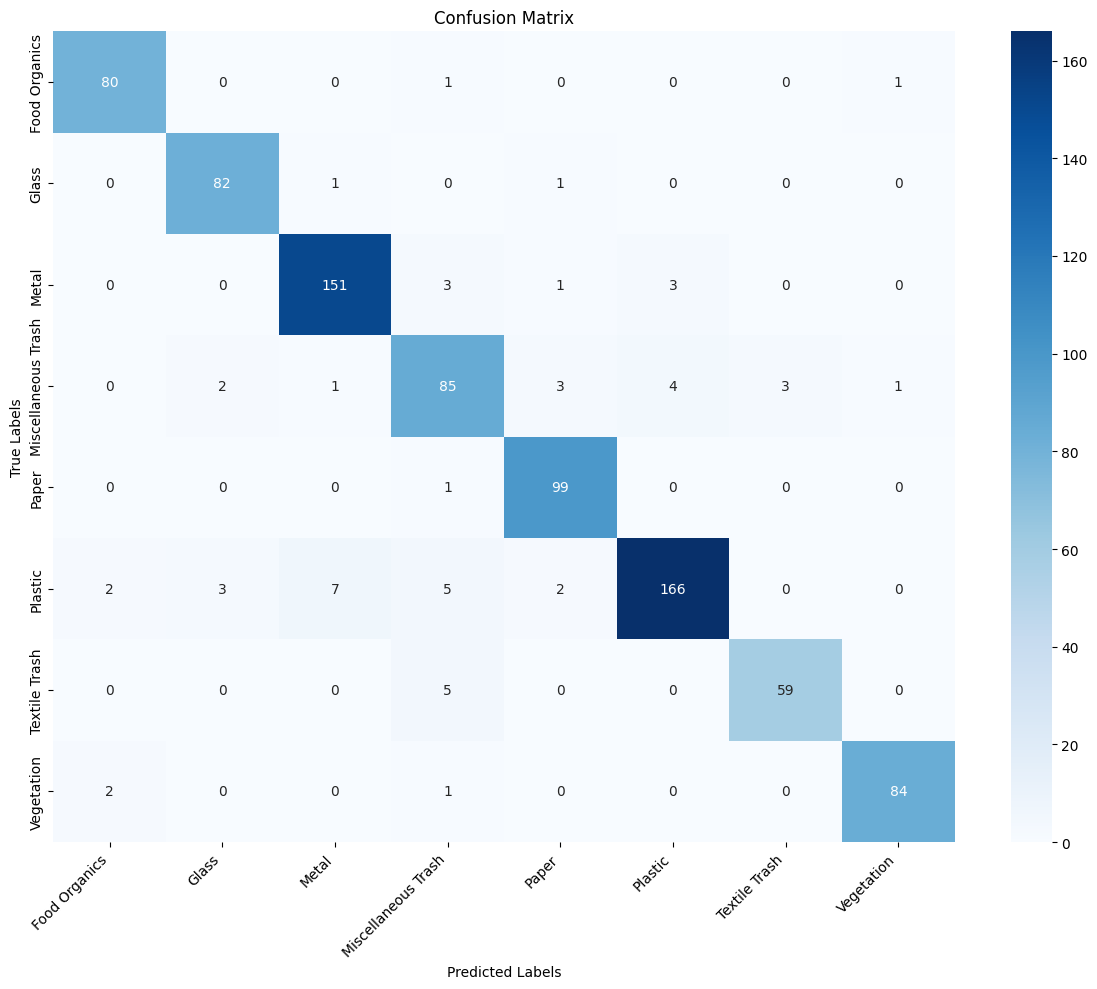

Overall accuracy: 0.9383
Accuracy for class 'Food Organics': 0.9756
Accuracy for class 'Glass': 0.9762
Accuracy for class 'Metal': 0.9557
Accuracy for class 'Miscellaneous Trash': 0.8586
Accuracy for class 'Paper': 0.9900
Accuracy for class 'Plastic': 0.8973
Accuracy for class 'Textile Trash': 0.9219
Accuracy for class 'Vegetation': 0.9655
Model saved to waste_classification_model.pth


In [ ]:
# Evaluate on validation set
val_accuracy, class_accuracy = evaluate_model(model, val_loader, class_names)

# Save the trained model
def save_model(model, class_names, save_path='waste_classification_model.pth'):
    model_info = {
        'model_state_dict': model.state_dict(),
        'class_names': class_names
    }
    torch.save(model_info, save_path)
    print(f"Model saved to {save_path}")

save_model(model, class_names)

# Function for prediction with more robust error handling
def predict_waste_image(image_path, model, class_names):
    try:
        # Load and preprocess the image
        transform = data_transforms['val']
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)

        # Make prediction
        model.eval()
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
            _, prediction = torch.max(outputs, 1)

        # Get predicted class and confidence
        predicted_class = class_names[prediction.item()]
        confidence = probabilities[prediction.item()].item()

        # Get top 3 predictions with probabilities
        top3_prob, top3_indices = torch.topk(probabilities, min(3, len(class_names)))
        top3_classes = [(class_names[idx.item()], prob.item()) for idx, prob in zip(top3_indices, top3_prob)]

        # Get recyclability info
        recyclability = get_recyclability_info(predicted_class)

        return {
            'success': True,
            'predicted_class': predicted_class,
            'confidence': confidence,
            'top3_classes': top3_classes,
            'recyclability': recyclability,
            'image': image
        }
    except Exception as e:
        return {
            'success': False,
            'error': str(e)
        }

## Helper Function: `get_recyclability_info`

The `get_recyclability_info` function is designed to provide useful information about the recyclability of a waste class based on its predicted category. It classifies the waste as either **Recyclable**, **Compostable**, or **Non-recyclable**, and provides a description of how to dispose of it properly.

### Function Breakdown:

The function takes the predicted waste class as input and returns the following information:

- **Recyclable**: Waste that can be processed and reused, such as glass, metal, paper, and plastics.
- **Compostable**: Organic waste that can be decomposed into compost, such as food scraps and vegetation.
- **Non-recyclable**: Waste that cannot be recycled or composted and should be disposed of in general waste.



In [ ]:
# Helper function to determine recyclability
def get_recyclability_info(waste_class):
    recyclable = ['glass', 'metal', 'paper', 'plastics']
    compostable = ['food_organics', 'vegetation']

    if waste_class in recyclable:
        return {
            'status': 'Recyclable',
            'description': f'{waste_class.replace("_", " ").title()} can be recycled. Place it in the appropriate recycling bin.'
        }
    elif waste_class in compostable:
        return {
            'status': 'Compostable',
            'description': f'{waste_class.replace("_", " ").title()} is compostable. It can be used for composting.'
        }
    else:
        return {
            'status': 'Non-recyclable',
            'description': f'{waste_class.replace("_", " ").title()} is generally not recyclable. It should go to general waste.'
        }


# Waste Image Classification Model: Prediction and Evaluation

## Overview
The model is designed to classify waste images into predefined categories such as recyclable, compostable, or non-recyclable. It uses a convolutional neural network (CNN) for image classification, trained on a custom dataset of waste items. After training, the model can predict the category of a given waste image and provide information about its recyclability.

## Prediction Workflow

### 1. **Prediction Function**: `predict_waste_image`
This function takes an image path, processes the image, and predicts its category using the trained model. It also returns the confidence score and top 3 predictions with probabilities.


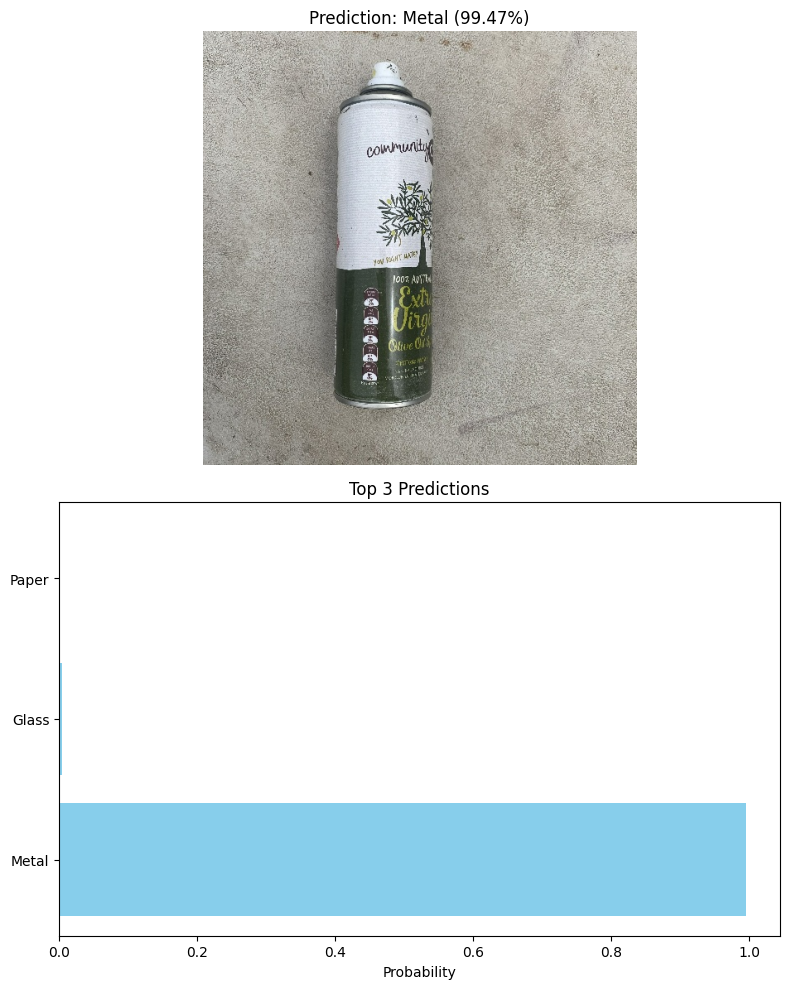

In [ ]:
# Example usage of prediction function
def display_prediction(image_path, model, class_names):
    result = predict_waste_image(image_path, model, class_names)

    if not result['success']:
        print(f"Error: {result['error']}")
        return

    plt.figure(figsize=(8, 10))

    # Display image with prediction title
    plt.subplot(2, 1, 1)
    plt.imshow(result['image'])
    plt.title(f"Prediction: {result['predicted_class'].replace('_', ' ').title()} ({result['confidence']:.2%})")
    plt.axis('off')

    # Plot top 3 predicted classes with probabilities
    plt.subplot(2, 1, 2)
    classes = [c.replace('_', ' ').title() for c, _ in result['top3_classes']]
    probabilities = [prob for _, prob in result['top3_classes']]
    plt.barh(classes, probabilities, color='skyblue')
    plt.title("Top 3 Predictions")
    plt.xlabel('Probability')
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
image_path = '/content/drive/MyDrive/Final_project/RealWaste/Metal/Metal_102.jpg'
display_prediction(image_path, model, class_names)


In [ ]:
# Example usage
image_path = '/content/drive/MyDrive/Final_project/RealWaste/Metal/Metal_102.jpg'
display_prediction(image_path, model, class_names)

NameError: name 'display_prediction' is not defined

In [ ]:
!pip install flask-ngrok pyngrok Pillow torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# waste_classifier_app.py
import os
import torch
from flask import Flask, request, render_template, jsonify
from werkzeug.utils import secure_filename
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms, models
import torch.nn as nn

app = Flask(__name__)

app.config['UPLOAD_FOLDER'] = 'static/uploads'
app.config['MAX_CONTENT_LENGTH'] = 16 * 1024 * 1024
os.makedirs(app.config['UPLOAD_FOLDER'], exist_ok=True)
os.makedirs('templates', exist_ok=True)
os.makedirs('static', exist_ok=True)

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Image transform
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def load_model(model_path='/content/waste_classification_model.pth'):
    try:
        # Check if model exists at the path
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found at: {model_path}")

        # Load checkpoint
        checkpoint = torch.load(model_path, map_location=device)

        # Extract class names from checkpoint
        class_names = checkpoint.get('class_names', None)
        if class_names is None:
            raise KeyError("'class_names' not found in checkpoint.")

        # Initialize EfficientNet B0 model
        model = models.efficientnet_b0(weights=None)
        num_ftrs = model.classifier[1].in_features

        # Modify the classifier layer
        model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_ftrs, 8)  # Assumes 8 classes in the model
        )

        # Load model state dictionary
        try:
            model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        except KeyError as ke:
            print(f"KeyError: {ke} - This might indicate mismatched model architecture.")
            return None, None
        except RuntimeError as re:
            print(f"RuntimeError: {re} - This could be due to incorrect weights or device issues.")
            return None, None

        # Move model to the appropriate device and set to evaluation mode
        model = model.to(device).eval()

        return model, class_names

    except FileNotFoundError as fnf:
        print(f"File not found: {fnf}")
        return None, None
    except KeyError as ke:
        print(f"KeyError: {ke}")
        return None, None
    except RuntimeError as re:
        print(f"RuntimeError: {re}")
        return None, None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None, None


def get_recyclability_info(label):
    data = {
        'food_organics': ('Compostable', 'Food waste can be composted.'),
        'glass': ('Recyclable', 'Glass is recyclable.'),
        'metal': ('Recyclable', 'Metal is recyclable.'),
        'paper': ('Recyclable', 'Paper is recyclable.'),
        'plastics': ('Recyclable', 'Check symbol and local rules.'),
        'textile_trash': ('Special Handling', 'Donate or recycle textiles.'),
        'vegetation': ('Compostable', 'Plant material is compostable.'),
        'miscellaneous_trash': ('Non-recyclable', 'Goes to landfill.')
    }
    status, description = data.get(label, ('Unknown', 'No data available.'))
    return {'status': status, 'description': description}

@app.route('/')
def index():
    model_status = 'loaded' if model else 'not loaded'
    return render_template('index.html', model_status=model_status)

@app.route('/classify', methods=['POST'])
def classify():
    if model is None:
        return jsonify({'error': 'Model not loaded'})

    file = request.files.get('file')
    if not file or file.filename == '':
        return jsonify({'error': 'No file selected'})

    try:
        filename = secure_filename(file.filename)
        path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        file.save(path)

        img = Image.open(path).convert('RGB')
        tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(tensor)
            probs = F.softmax(output, dim=1)[0]

        top_probs, top_indices = torch.topk(probs, 3)
        top_preds = [{
            'class': class_names[i.item()].replace('_', ' ').title(),
            'raw_class': class_names[i.item()],
            'probability': p.item()
        } for i, p in zip(top_indices, top_probs)]

        recyclability = get_recyclability_info(top_preds[0]['raw_class'])

        return jsonify({
            'top_predictions': top_preds,
            'recyclability': recyclability,
            'image_path': f"/{path}"
        })

    except Exception as e:
        return jsonify({'error': str(e)})

# Load model
model, class_names = load_model()

# Run the app
if __name__ == '__main__':
    app.run()


Using device: cuda
Error loading model: Error(s) in loading state_dict for EfficientNet:
	size mismatch for features.3.0.block.3.0.weight: copying a param with shape torch.Size([48, 144, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 144, 1, 1]).
	size mismatch for features.3.0.block.3.1.weight: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.3.0.block.3.1.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.3.0.block.3.1.running_mean: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.3.0.block.3.1.running_var: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.3.1.block.0.0.weight: copying a param with shape torch.Si

INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
